# 2D ERT modeling and inversion (Complex)
### This one tries to copy the deposit shape and simulate the geothermal plume as a diffusing fluid

There are also some changes to optimize the geometry and the inversion

In [53]:
import matplotlib.pyplot as plt
import numpy as np

import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics import ert

## Geometry definition

In [54]:
world = mt.createWorld(start=(-350, -250), end=(350, 0))

### Define geology below the deposit

Fault and inyection point definition

In [55]:
iPos = (-125, -200) #Inyection Point
iPos2 = (125, -200) #Inyection Point 2
fault = mt.createPolygon([iPos, (-150, -250)], isClosed= True)

Define Floresta and Cretacic

In [56]:
layer = mt.createPolygon([(-350, -150), iPos, (350, -150)], 
                         addNodes=100, interpolate='spline', isClosed=False)

Define Geometry

(<Axes: >, None)

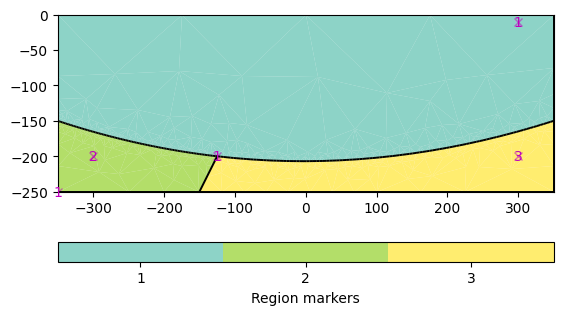

In [57]:
world += layer
world += fault

world.addRegionMarker((300, -10), marker=1)
world.addRegionMarker((-300, -200), marker=2)
world.addRegionMarker((300, -200), marker=3)

pg.show(world)

## Synthetic data generation
Create a Schlumberger ('slm') measuring scheme with 96 electrodes along a 700m line (-350 to 350)


(<Axes: >, None)

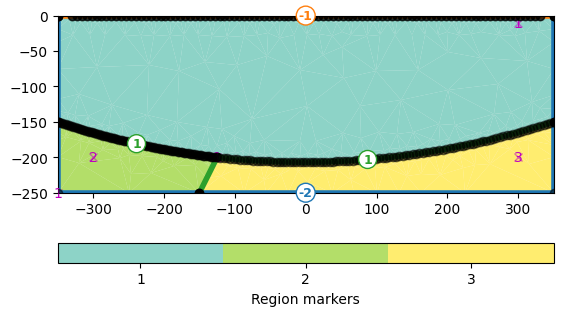

In [58]:
# Sensors should no be on the corner so we put them a little inside
scheme = ert.createData(elecs=np.linspace(start=-330, stop=330, num=96),
                           schemeName='slm')

# we need local refinement at the electrodes to achieve sufficient accuracy
for p in scheme.sensors():
    world.createNode(p)
    world.createNode(p - [0, 0.1])

pg.show(world, markers=True, showNodes=True)

**IMPORTANT:** Mesh needs to be created after adding electrodes to world geometry

In [59]:
mesh = mt.createMesh(world, quality=33, area=100)

We need larger boundary to avoid numerical issues.
Note: appendTriangleBoundary is just an easier approach, but we can get better results if we create the boundary manually on geometry level.

(<Axes: >, <matplotlib.colorbar.Colorbar at 0x7faab4988ac0>)

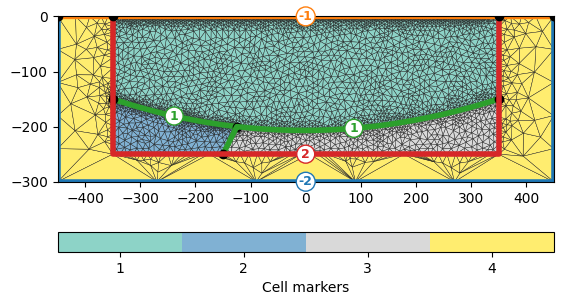

In [60]:
mesh = mt.appendTriangleBoundary(mesh, xbound=100, ybound=50, marker=4)

pg.show(mesh, markers=True, showMesh=True)

Add rho values to our mesh

(<Axes: >, <matplotlib.colorbar.Colorbar at 0x7faab4af19f0>)

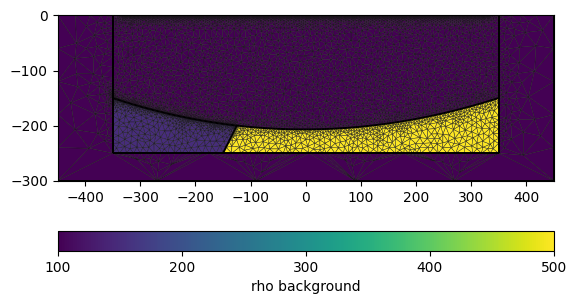

In [61]:
rhoMin = 1
rhoMax = 100
rho0 = pg.solver.cellValues(mesh, {1: 100,
                                   2: 150,
                                   3: 500,
                                   4: 100,}
                                   )

pg.show(mesh, rho0, label='rho background', showMesh=True)

Simulate the ert with our forward mesh

ModellingBase::setMesh() copying new mesh ... Found datafile: 96 electrodes
Found: 96 free-electrodes
rMin = 3.47368, rMax = 1320
NGauLeg + NGauLag for inverse Fouriertransformation: 15 + 4
Found non-Neumann domain
2.01865 s
FOP updating mesh dependencies ... 1.7e-06 s
Calculating response for model: min = 100 max = 500
Allocating memory for primary potential...... 0.0067435

No primary potential for secondary field calculation. Calculating analytically...
Forward: time: 2.69908s
Response: min = 99.8372 max = 110.082 mean = 102.103
Reciprocity rms(modelReciprocity) 0.0146073%, max: 0.0224795%
relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100
Data error estimate (min:max)  0.030000436471396982 : 0.03044701914958582


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x7faab50923b0>)

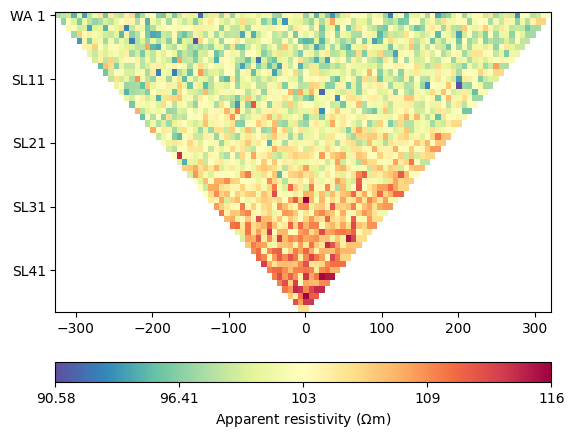

In [62]:
data = ert.simulate(mesh, scheme=scheme, res=rho0, 
                    noiseLevel=3, noiseAbs=1e-6, seed=1337)

pg.show(data)

### Define diffusive fluid

The flow can be either anisotropic or isotropic

Mesh:  Mesh: Nodes: 9739 Cells: 17899 Boundaries: 27637
Assembling time:  0.381693932
Solving time:  0.546534145


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x7faa99bc9f00>)

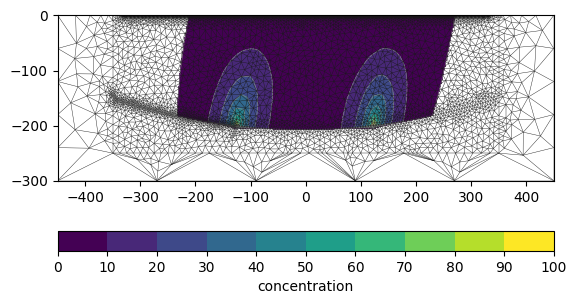

In [63]:
#Anisotropic flow
diff = pg.solver.cellValues(mesh, {'3,2,4': pg.solver.createAnisotropyMatrix(0.1, 0.1, 0.0), 1: pg.solver.createAnisotropyMatrix(1, 100, 20.0*np.pi/180)}) 

#Isotropic and homogeneous flow
#diff = pg.solver.cellValues(mesh, {4: 1e-2, 3: 1e-2, 2: 1e-2, 1: 100}) 

iPosID = mesh.findNearestNode(iPos)
iPosID2 = mesh.findNearestNode(iPos2)

# stationary solution 
Conc = pg.solver.solve(mesh, a=diff,
                    bc={'Dirichlet': {'-1': 0.0}, 'Neumann': {'-2': -1},
                        'Node':[[iPosID, 100], [iPosID2, 100]]}, verbose=True)

pg.show(mesh, Conc, label='concentration', showMesh=True, 
        cMin=0, cMax=100, nCols=10, nLevs=11, linewidths=0.5)

### Simulate resistivity of the diffusive fluid according to the concentration

In [64]:
Conc = pg.interpolate(mesh, Conc, mesh.cellCenters())
Conc[Conc < 0] = 0

# add anomal resistivity as linear function from rhoMin to rhoMax depending on concentration
rho = 1/(1/np.array(rho0) + 1/(rhoMin)*(Conc/100))

In [65]:
data = ert.simulate(mesh, scheme=scheme, res=rho, noiseLevel=3,
                    noiseAbs=1e-6, seed=1337)

pg.info(np.linalg.norm(data['err']), np.linalg.norm(data['rhoa']))
pg.info('Simulated data', data)
pg.info('The data contains:', data.dataMap().keys())

pg.info('Simulated rhoa (min/max)', min(data['rhoa']), max(data['rhoa']))
pg.info('Selected data noise %(min/max)', min(data['err'])*100, max(data['err'])*100)

31/08/23 - 17:39:51 - pyGIMLi - INFO - 1.426462397915126 2152.558725904345
31/08/23 - 17:39:51 - pyGIMLi - INFO - Simulated data Data: Sensors: 96 data: 2209, nonzero entries: ['a', 'b', 'err', 'k', 'm', 'n', 'rhoa', 'valid']
31/08/23 - 17:39:51 - pyGIMLi - INFO - The data contains: ['a', 'b', 'err', 'i', 'ip', 'iperr', 'k', 'm', 'n', 'r', 'rhoa', 'u', 'valid']
31/08/23 - 17:39:51 - pyGIMLi - INFO - Simulated rhoa (min/max) 12.4560555650122 105.61990126203548
31/08/23 - 17:39:51 - pyGIMLi - INFO - Selected data noise %(min/max) 3.000043651196751 3.206590159298907


ModellingBase::setMesh() copying new mesh ... relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100
Data error estimate (min:max)  0.03000043651196751 : 0.03206590159298907
Found datafile: 96 electrodes
Found: 96 free-electrodes
rMin = 3.47368, rMax = 1320
NGauLeg + NGauLag for inverse Fouriertransformation: 15 + 4
Found non-Neumann domain
0.131797 s
FOP updating mesh dependencies ... 3e-06 s
Calculating response for model: min = 1.16195 max = 500
Allocating memory for primary potential...... 0.0090938

No primary potential for secondary field calculation. Calculating analytically...
Forward: time: 2.55337s
Response: min = 14.0142 max = 100.001 mean = 39.9445
Reciprocity rms(modelReciprocity) 2.50058%, max: 14.4747%


Filter all values and tokens in the data container.
Its possible that there are some negative data values due to noise and
huge geometric factors. So we need to remove them.



31/08/23 - 17:39:51 - pyGIMLi - INFO - Filtered rhoa (min/max) 12.4560555650122 105.61990126203548


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x7faa9aa16620>)

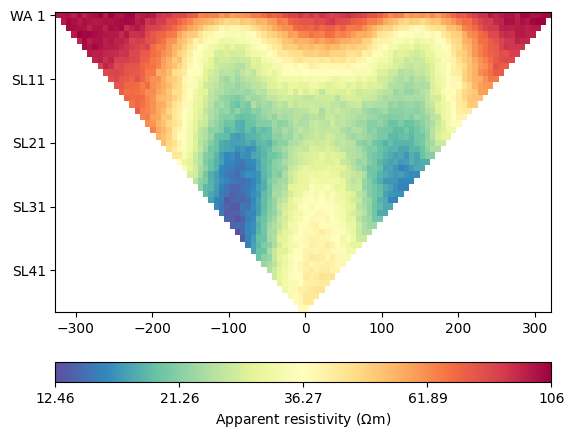

In [66]:
data.remove(data['rhoa'] < 0)
pg.info('Filtered rhoa (min/max)', min(data['rhoa']), max(data['rhoa']))

# You can save the data for further use
data.save('Forward_mod.dat')

# You can take a look at the data
ert.show(data)

## Inversion with the ERTManager
Initialize the ERTManager, e.g. with a data container or a filename.



In [67]:
mgr = ert.ERTManager('Forward_mod.dat')

Run the inversion with the preset data. 
Since I set noise level to 3%, chi^2 target should be close to 0.9 or sighly above, also the regularization parameter should be in the range of 10 to 50 (I chose 30).



In [68]:
inv = mgr.invert(lam=30, verbose=True)
np.testing.assert_approx_equal(mgr.inv.chi2(), 0.9, significant=1)

31/08/23 - 17:40:04 - pyGIMLi - INFO - Found 2 regions.
31/08/23 - 17:40:04 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
31/08/23 - 17:40:04 - pyGIMLi - INFO - Found 2 regions.
31/08/23 - 17:40:04 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
31/08/23 - 17:40:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
31/08/23 - 17:40:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
31/08/23 - 17:40:05 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 3623 Cells: 6784 Boundaries: 5318


Constructing Delaunay triangulation by divide-and-conquer method.
Delaunay milliseconds:  0
Recovering segments in Delaunay triangulation.
Segment milliseconds:  0
Removing unwanted triangles.
Spreading regional attributes and area constraints.
Hole milliseconds:  0
Adding Steiner points to enforce quality.
Quality milliseconds:  1

Writing vertices.
Writing triangles.
Writing segments.
Writing edges.

Output milliseconds:  1
Total running milliseconds:  2

Statistics:

  Input vertices: 199
  Input segments: 200
  Input holes: 0

  Mesh vertices: 964
  Mesh triangles: 1696
  Mesh edges: 2659
  Mesh exterior boundary edges: 230
  Mesh interior boundary edges: 27
  Mesh subsegments (constrained edges): 257



31/08/23 - 17:40:05 - pyGIMLi - INFO - Use median(data values)=31.6281892083006
31/08/23 - 17:40:05 - pyGIMLi - INFO - Created startmodel from forward operator: 1415 [31.6281892083006,...,31.6281892083006]
31/08/23 - 17:40:05 - pyGIMLi - INFO - Starting inversion.


min/max(dweight) = 31.1858/33.3328
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x7faa9af6fe70>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x7faa99bcfb50>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x7faa9af6d440>
min/max (data): 12.46/106
min/max (error): 3%/3.21%
min/max (start model): 31.63/31.63
--------------------------------------------------------------------------------
Calculating response for model: min = 31.6282 max = 31.6282
Allocating memory for primary potential...... 1.49711

No primary potential for secondary field calculation. Calculating analytically...
Forward: time: 2.47733s
Response: min = 31.5717 max = 31.6333 mean = 31.6207
Reciprocity rms(modelReciprocity) 0%, max: 0%
min/max(dweight) = 31.1858/33.3328
Building constraints matrix
constraint matrix of size(nBounds x nModel) 2011 x 1415
check Jacobian: wrong dimensions: (0x0) should be (2209x1415)  force: 1
jacobian size invalid, forced recalc: 1
calculating jac

Let the ERTManger show you the model of the last successful run and how it
fits the data. 
## Show data, model response, and model.



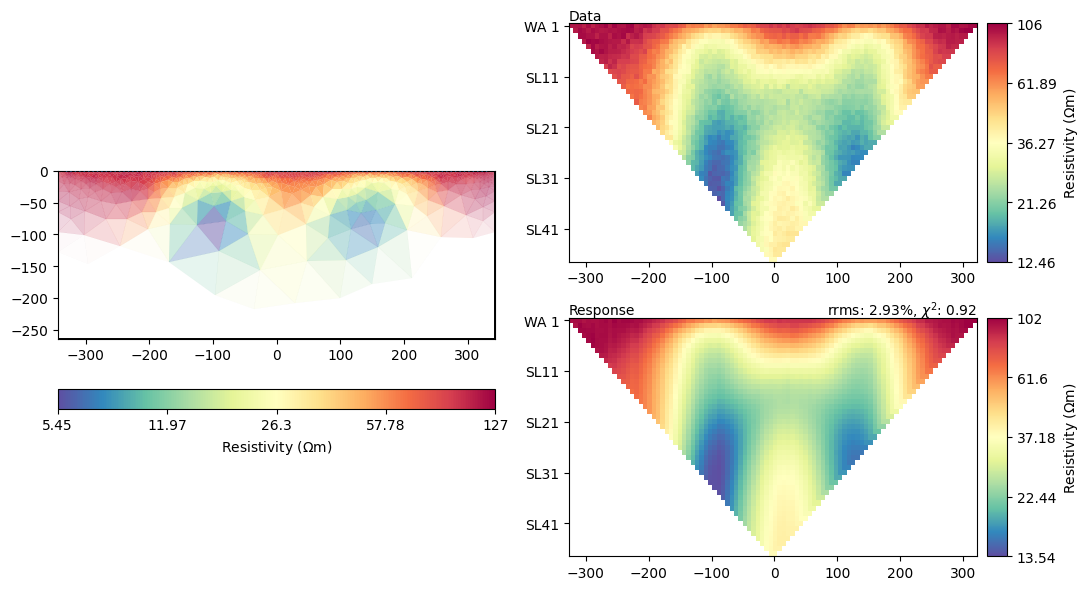

In [69]:
mgr.showResultAndFit()
meshPD = pg.Mesh(mgr.paraDomain) # Save copy of para mesh for plotting later